In [517]:
import numpy as np
import matplotlib.pyplot as plt
from copy import copy
from ll4ma_movement_primitives.basis_functions import GaussianLinearBFS
from ll4ma_movement_primitives.phase_variables import LinearPV

In [521]:
import os
import rospy
import numpy as np
from sklearn.covariance import empirical_covariance, shrunk_covariance, oas, ledoit_wolf
from scipy import interpolate
from sklearn import linear_model
import cPickle as pickle
import seaborn as sns
import matplotlib.pyplot as plt
from rospy_service_helper import get_task_trajectories
from ll4ma_movement_primitives.promps import ProMP, ProMPConfig

lib_file = os.path.expanduser("~/.rosbags/demos/promp_backup/promp_lib_062.pkl")
with open(lib_file, 'r') as f:
    lib = pickle.load(f)
promp = lib.get_promp("DEFAULT")
promp.w.shape
rospy.init_node("test_cov")

In [522]:
def get_data_trajs(j_trajs=[], ee_trajs=[], obj_trajs=[]):
    num_trajectories = max(len(j_trajs), len(ee_trajs), len(obj_trajs))
    data = {}
    for i in range(num_trajectories):
        data_i = {}
        trajectory_name = None
        # Add joint trajectory data
        if j_trajs:
            qs = dqs = xs = obj_xs = None
            for j_point in j_trajs[i].points:
                q = np.array(j_point.positions)[:,None]
                qs =  q if qs is None else np.hstack((qs, q))
                dq = np.array(j_point.velocities)[:,None]
                dqs = dq if dqs is None else np.hstack((dqs, dq))
            data_i['q']    = qs
            data_i['qdot'] = dqs
            trajectory_name = j_trajs[i].trajectory_name
        # Add end-effector trajectory
        if ee_trajs:
            xs = None
            for ee_point in ee_trajs[i].points:
                x = []
                x.append(ee_point.pose.position.x)
                x.append(ee_point.pose.position.y)
                x.append(ee_point.pose.position.z)
                x.append(ee_point.pose.orientation.x)
                x.append(ee_point.pose.orientation.y)
                x.append(ee_point.pose.orientation.z)
                x.append(ee_point.pose.orientation.w)
                x = np.array(x).reshape((7,1))
                xs = x if xs is None else np.hstack((xs, x))
            data_i['x'] = xs[:3,:] # TODO TEMPORARY
            trajectory_name = ee_trajs[i].trajectory_name
        # Add object trajectory
        if obj_trajs:
            obj_xs = None
            for obj_point in obj_trajs[i].points:
                obj_x = []
                obj_x.append(obj_point.pose.position.x)
                obj_x.append(obj_point.pose.position.y)
                obj_x.append(obj_point.pose.position.z)
                obj_x.append(obj_point.pose.orientation.x)
                obj_x.append(obj_point.pose.orientation.y)
                obj_x.append(obj_point.pose.orientation.z)
                obj_x.append(obj_point.pose.orientation.w)
                obj_x = np.array(obj_x).reshape((7,1))
                obj_xs = obj_x if obj_xs is None else np.hstack((obj_xs, obj_x))
            data_i['obj_x'] = obj_xs[:3,:] # TODO TEMPORARY
            trajectory_name = obj_trajs[i].trajectory_name
        data[trajectory_name] = data_i
    return data

def get_config_from_data(data):
    config = ProMPConfig()
    demos = []
    for demo_name in data.keys():
        ds = None
        config.state_types = []
        config.dimensions = []
        for state_type in data[demo_name].keys():
            dimensions = []
            for dim in range(data[demo_name][state_type].shape[0]):
                dimensions.append(dim)
                d = data[demo_name][state_type][dim][:,None]
                ds = d if ds is None else np.vstack((ds,d))
            config.state_types.append(state_type)
            config.dimensions.append(dimensions)
            print ds.shape
        demos.append(ds)
    return config, demos

traj_idxs = range(58,68)
names = ["trajectory_%03d" % idx for idx in traj_idxs]
t_trajs = get_task_trajectories("/pandas/get_task_trajectories", "end_effector", names)
data = get_data_trajs(ee_trajs=t_trajs)
d1_demos = [data[key]['x'][1] for key in data.keys()]

interp = None
for d1_demo in d1_demos:
    t = np.linspace(0.0, 10.0, len(d1_demo))
    f = interpolate.interp1d(t, d1_demo)
    dim_data = f(np.linspace(0.0, 10.0, 1000))
    interp = dim_data if interp is None else np.vstack((interp, dim_data))

plt.figure()
for i in range(interp.shape[0]):
    plt.plot(interp[i,:])
plt.show()

[ERROR] [1536026023.027143]: Service request to get task trajectories failed: service [/pandas/get_task_trajectories] returned no response


TypeError: object of type 'NoneType' has no len()

In [400]:
def get_phi(x, num_demos=5, num_pts=100, num_bfs=10):
    """
    xs should have shape (num_pts, 1)
    
    This assumes right now that each traj has the same number of time points, but that will not generally
    be true unless you do time alignment somehow
    
    phi has shape (num_demos * num_pts, num_bfs)
    """
    bfs = GaussianLinearBFS()
    phi = bfs.get_rollout(x)
    phis = None
    for i in range(num_demos):
        phis = phi if phis is None else np.vstack((phis, phi))
    return phis
    # return np.random.random((num_demos * num_pts, num_bfs))

def evidence_approximation(taus, x, alpha_0=0.0, beta_0=0.0, num_bfs=10, max_iter=1000, tolerance=1e-8):
    """
    Returns:
        alpha  : alpha value on convergence, None if not converged
        beta   : beta value on convergence, None if not converged
        alphas : list of all alpha values computed during procedure
        betas  : list of all beta values computed during procedure
    """
    N     = taus.shape[0]
    M     = num_bfs
    alpha = copy(alpha_0)
    beta  = copy(beta_0)
   
    # These are for plotting on return
    alphas = [alpha]
    betas  = [beta]
    
    num_demos, num_pts = taus.shape
    # Vectorize the trajs
    ys = None
    for i in range(num_demos):
        ys = taus[i,:] if ys is None else np.hstack((ys, taus[i,:]))
    xs = np.tile(x, num_demos)
    phi = get_phi(x, num_demos, num_pts)
    
    phiT_phi = np.dot(phi.T, phi)
    eigs, _  = np.linalg.eig(phiT_phi)
    
    for i in range(max_iter):
        beta_eigs = beta * eigs
        
        # Compute new gamma
        gamma = 0
        for m in range(M):
            gamma += beta_eigs[m] / (beta_eigs[m] + alpha)
            
        #print "GAMMA", gamma
            
        # Compute new beta
        A        = (alpha * np.eye(M)) + (beta * phiT_phi)
        A_inv    = np.linalg.pinv(A)
        m_N      = beta * np.dot(A_inv, np.dot(phi.T, ys)) # TODO no clue how dimensions will line up for taus
        sum_sqrs = np.linalg.norm(ys - np.dot(phi, m_N))**2
        beta_inv = (1.0 / (N - gamma)) * sum_sqrs
        beta     = 1.0 / beta_inv
        
        # Compute new alpha
        alpha = gamma / np.dot(m_N.T, m_N)
        
        # Check convergence
        if abs(alphas[-1] - alpha) < tolerance and abs(betas[-1] - beta) < tolerance:
            print "CONVERGED at iteration %d" % i
            return alpha, beta, alphas, betas, phi
    
        alphas.append(alpha)
        betas.append(beta)
        
    print "NO CONVERGENCE"
    return None, None, alphas, betas, None

In [425]:
def murphy_approximation(taus, x, alpha, beta, num_bfs=10, max_iter=10000, tolerance=1e-8):
    N     = taus.shape[0]
    M     = num_bfs
   
    # These are for plotting on return
    alphas = [alpha]
    betas  = [beta]
    
    num_demos, num_pts = taus.shape
    # Vectorize the trajs
    ys = None
    for i in range(num_demos):
        ys = taus[i,:] if ys is None else np.hstack((ys, taus[i,:]))
    xs = np.tile(x, num_demos)
    phi = get_phi(x, num_demos, num_pts)
    
    for i in range(max_iter):
        # E step
        A = alpha * np.eye(M)
        sigma_inv = beta * np.dot(phi.T, phi) + A
        sigma = np.linalg.pinv(sigma_inv)
        mu = beta * np.dot(sigma, np.dot(phi.T, ys))
        # M step
        alpha = float(M) / (np.dot(mu.T, mu) + np.trace(sigma))
        sum_val = 0.0
        for j in range(M):
            sum_val += 1 - (alpha * sigma[j,j])
        beta_inv = (1.0 / N) * (np.linalg.norm(ys - np.dot(phi, mu))**2 + (1.0 / beta) * sum_val)
        beta = 1.0 / beta_inv
        
        # Check convergence
        if abs(alphas[-1] - alpha) < tolerance and abs(betas[-1] - beta) < tolerance:
            print "CONVERGED at iteration %d" % i
            return alpha, beta, alphas, betas, phi
    
        alphas.append(alpha)
        betas.append(beta)
        
    print "NO CONVERGENCE"
    return None, None, alphas, betas, None

CONVERGED at iteration 4
alpha 0.74681119018
beta 0.0481635797703


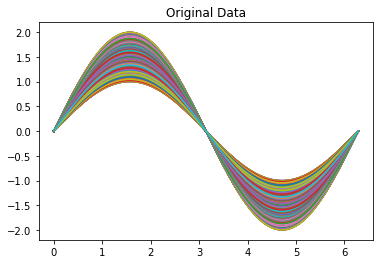

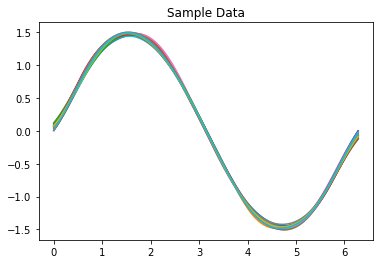

In [505]:
from scipy.stats import norm
import random

def run_example(alpha_0, beta_0, num_demos=5, num_pts=500):
    # Generate data
    t = np.linspace(0.0, 2*np.pi, num_pts)
    pv = LinearPV(max_time = 2*np.pi)
    x = pv.get_rollout(2*np.pi / float(num_pts))
    ys = None
    for i in range(num_demos):
        y = random.uniform(1.0, 2.0) * np.sin(t)# + norm(0, 0.1).rvs(num_pts)
        ys = y if ys is None else np.vstack((ys, y))
    
    # alpha, beta, alphas, betas, phi = evidence_approximation(ys, x, alpha_0, beta_0)
    alpha, beta, alphas, betas, phi = murphy_approximation(ys, x, alpha_0, beta_0)
    print "alpha", alpha
    print "beta", beta
    
    if alpha is not None:
        # Vectorize the trajs
        vec = None
        for i in range(num_demos):
            vec = ys[i,:] if vec is None else np.hstack((vec, ys[i,:]))
        S_N_inv = alpha * np.eye(10) + beta * np.dot(phi.T, phi)
        S_N = np.linalg.pinv(S_N_inv)
        m_N = beta * np.dot(S_N, np.dot(phi.T, vec))
        
        bfs = GaussianLinearBFS()
        phi = bfs.get_rollout(x)
        
        mu_traj = np.dot(phi, m_N)
        

    # Plot
    plt.figure()
    plt.title("Original Data")
    for i in range(num_demos):
        plt.plot(t, ys[i,:])
    if alpha is not None:
        plt.figure()
        plt.title("Sample Data")
        # plt.plot(t, mu_traj, lw=5.0)
        for i in range(20):
            sample = np.random.multivariate_normal(m_N, S_N)
            plt.plot(t, np.dot(phi, sample))
    plt.show()
    
run_example(0.0, 0.01, num_demos=1000)

CONVERGED at iteration 53
alpha 1.63493516622
beta 0.0646373514933


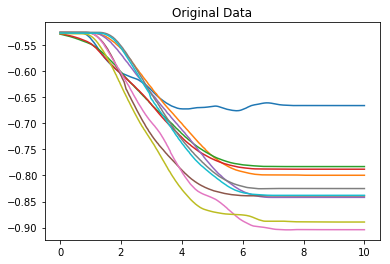

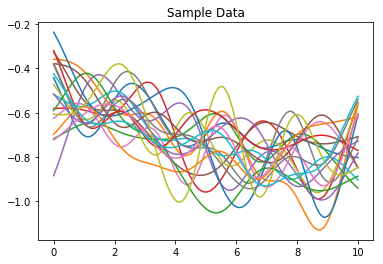

In [515]:
from scipy.stats import norm
import random

def run_example(alpha_0, beta_0):
    # Generate data
    t = np.linspace(0.0, 10.0, 1000)
    pv = LinearPV(max_time=10.0)
    x = pv.get_rollout(10.0 / 1000.0)
    ys = interp
    
    # alpha, beta, alphas, betas, phi = evidence_approximation(ys, x, alpha_0, beta_0)
    alpha, beta, alphas, betas, phi = murphy_approximation(ys, x, alpha_0, beta_0)
    print "alpha", alpha
    print "beta", beta
    
    if alpha is not None:
        # Vectorize the trajs
        vec = None
        for i in range(interp.shape[0]):
            vec = ys[i,:] if vec is None else np.hstack((vec, ys[i,:]))
        S_N_inv = alpha * np.eye(10) + beta * np.dot(phi.T, phi)
        S_N = np.linalg.pinv(S_N_inv)
        m_N = beta * np.dot(S_N, np.dot(phi.T, vec))
        
        bfs = GaussianLinearBFS()
        phi = bfs.get_rollout(x)
        
        mu_traj = np.dot(phi, m_N)
        

    # Plot
    plt.figure()
    plt.title("Original Data")
    for i in range(interp.shape[0]):
        plt.plot(t, ys[i,:])
    if alpha is not None:
        plt.figure()
        plt.title("Sample Data")
        # plt.plot(t, mu_traj, lw=5.0)
        for i in range(20):
            sample = np.random.multivariate_normal(m_N, S_N)
            plt.plot(t, np.dot(phi, sample))
    plt.show()
    
run_example(0.0, 0.1)